In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import missingno as msn

In [2]:
df = pd.read_csv('diabetes.csv')

In [3]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [4]:
df.drop(['SkinThickness', 'Insulin'],axis=1,inplace=True)

In [5]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'BMI',
       'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [6]:
df['Glucose'] = df['Glucose'].apply(lambda x: df['Glucose'].mean() if x== 0 else x)

In [7]:
df['BloodPressure'] = df['BloodPressure'].apply(lambda x: df['BloodPressure'].mean() if x== 0 else x)

In [8]:
df['BMI'] = df['BMI'].apply(lambda x: df['BMI'].mean() if x== 0 else x)

<AxesSubplot:>

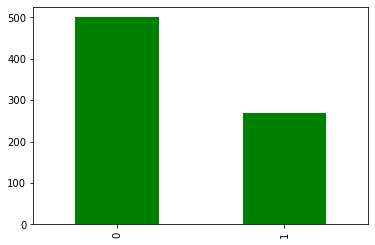

In [9]:
df['Outcome'].value_counts().plot(kind='bar',color='green')

In [10]:
y = df['Outcome']
X = df.drop('Outcome',axis=1)

In [11]:
from imblearn.over_sampling import RandomOverSampler
from collections import Counter

os=RandomOverSampler(1)
X_ns,y_ns=os.fit_sample(X,y)
print("The number of classes before fit {}".format(Counter(y)))
print("The number of classes after fit {}".format(Counter(y_ns)))

The number of classes before fit Counter({0: 500, 1: 268})
The number of classes after fit Counter({1: 500, 0: 500})


C:\Users\Acer\anaconda3\lib\site-packages\imblearn\utils\_validation.py:638: FutureWarning: Pass sampling_strategy=1 as keyword args. From version 0.9 passing these as positional arguments will result in an error
  FutureWarning)


In [12]:
X = X_ns
y = y_ns

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3,random_state=40)

In [14]:
from sklearn.ensemble import RandomForestClassifier

In [15]:
xgb = RandomForestClassifier()

In [16]:
xgb.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [17]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 2000, num = 100)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in range(100,2000,2)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]

In [18]:
grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [19]:
from sklearn.model_selection import StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True)

In [20]:
from sklearn.model_selection import RandomizedSearchCV
xgb_random = RandomizedSearchCV(estimator=xgb, param_distributions=grid, n_jobs=-1,n_iter = 50, cv=cv, scoring='accuracy',error_score=0)

In [21]:
xgb_random.fit(X_train,y_train)

RandomizedSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
                   error_score=0, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [100, 102, 104, 106, 108,
                                                      110, 112, 114, 116, 118,
                                                      120, 122, 124, 126, 128,
                                                      130, 132, 134, 136, 138,
                                                      140, 142, 144, 146, 148,
                                                      150, 152, 154, 156, 158, ...],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                      

In [22]:
best_model = xgb_random.best_estimator_

In [23]:
best_model

RandomForestClassifier(max_depth=750, n_estimators=1616)

In [24]:
xgb_random.best_params_

{'n_estimators': 1616,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 750,
 'bootstrap': True}

In [25]:
xgb_random.best_score_

0.8414285714285714

In [26]:
y_pred = best_model.predict(X_test)

In [27]:
err  =(y_pred- y_test)

<AxesSubplot:>

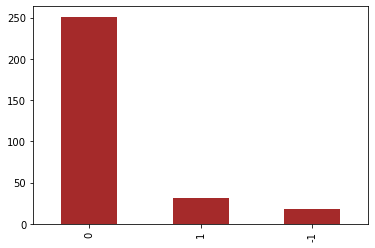

In [28]:
err.value_counts().plot(kind='bar',color='brown')

In [29]:
from sklearn import metrics
print('MAE:', metrics.mean_absolute_error(y_test,y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

MAE: 0.16333333333333333
MSE: 0.16333333333333333
RMSE: 0.40414518843273806


In [30]:
from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[115  31]
 [ 18 136]]
              precision    recall  f1-score   support

           0       0.86      0.79      0.82       146
           1       0.81      0.88      0.85       154

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300



In [31]:
import pickle
# open a file, where you ant to store the data
file = open('random_forest_diabetes.pkl', 'wb')
# dump information to that file
pickle.dump(best_model, file)
file.close()